# MoleculeNet BACE1 with XGBoost and Bayesian Hyperparameter Optimization

### Import and Load Data

In [2]:
import scipy
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import optuna
import xgboost as xgb

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay

MG_RADIUS = 2
MG_FPSIZE = 2048

/opt/homebrew/anaconda3/envs/rdkit-practice/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mfpgen = rdFingerprintGenerator.GetMorganGenerator(MG_RADIUS, MG_FPSIZE)

def smile2vector(smile):
    mol = Chem.MolFromSmiles(smile)
    if mol is None: 
        return None
    fp_array = mfpgen.GetFingerprintAsNumPy(mol)
    return fp_array

In [ ]:
data = pd.read_csv('bace.csv') 
# data["mol"].to_csv("bace.smi", index=False, header=False)
X = np.stack(data['mol'].apply(smile2vector))
X = scipy.sparse.csr_matrix(X)
y = data['Class'].values # .reshape(-1, 1)

data.info()
X.shape, y.shape

<class 'pandas.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Columns: 595 entries, mol to canvasUID
dtypes: float64(210), int64(382), str(3)
memory usage: 6.9 MB


((1513, 2048), (1513,))

## Configuration

In [5]:
TEST_SIZE = 0.1
VAL_SIZE = 0.2
RANDOM_STATE = 42
N_TRIALS = 100

In [6]:
STATIC_PARAMS = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'n_estimators': 2000,
    'n_jobs': -1,
    'random_state': 42,
    'early_stopping_rounds': 50,
}

PARAMS = lambda trial: {
    **STATIC_PARAMS,
            
    'max_depth': trial.suggest_int('max_depth', 3, 10),

    'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
    'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),

    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.8),
    'subsample': trial.suggest_float('subsample', 0.5, 0.9),

    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),

    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
}

## Setup

In [7]:
def create_data_split(X, y, test_size=TEST_SIZE, val_size=VAL_SIZE, random_state=RANDOM_STATE):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(1-test_size), random_state=random_state, stratify=y_train_val
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
def objective(trial, X_train, y_train, X_val, y_val):
    model = xgb.XGBClassifier(**PARAMS(trial))

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )

    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    
    return auc

In [9]:
def optimize(objective, n_trials=100):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params.copy()
    return best_params, study.best_value

## Train

In [16]:
X_train, X_val, X_test, y_train, y_val, y_test = create_data_split(X, y)
X_train_full = scipy.sparse.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

print("Starting optimization...")
best_params, best_value = optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=N_TRIALS)
best_params.update(STATIC_PARAMS)
print("\n\n\n------------------------------------------------\n\n\n")
print("Best value (AUC):", best_value)
print("Best params:", best_params)
print("\n\n\n------------------------------------------------\n\n\n")

print("Retraining best model on full training set...")
model = xgb.XGBClassifier(**best_params)

model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_test, y_test)],
    verbose=True
)

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

print("----------------- Model Evaluation -----------------")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[I 2026-02-03 20:48:01,684] A new study created in memory with name: no-name-7803182a-7c62-4cfe-bb5b-9e9538fb19af


Starting optimization...


[I 2026-02-03 20:48:03,338] Trial 0 finished with value: 0.8879007465963987 and parameters: {'max_depth': 4, 'reg_alpha': 0.2609073681756629, 'reg_lambda': 3.760249024867269, 'colsample_bytree': 0.4859272544689439, 'subsample': 0.5632957121526697, 'learning_rate': 0.015540653609117912, 'min_child_weight': 7}. Best is trial 0 with value: 0.8879007465963987.
[I 2026-02-03 20:48:04,795] Trial 1 finished with value: 0.9017786561264822 and parameters: {'max_depth': 10, 'reg_alpha': 0.143151899698977, 'reg_lambda': 0.005952920792477887, 'colsample_bytree': 0.3068634964074823, 'subsample': 0.8594279211601502, 'learning_rate': 0.146141960344606, 'min_child_weight': 6}. Best is trial 1 with value: 0.9017786561264822.
[I 2026-02-03 20:48:06,367] Trial 2 finished with value: 0.8865612648221344 and parameters: {'max_depth': 9, 'reg_alpha': 6.680302582860017, 'reg_lambda': 0.004611259052757292, 'colsample_bytree': 0.439080480417672, 'subsample': 0.8205447631448761, 'learning_rate': 0.03869454944533




------------------------------------------------



Best value (AUC): 0.9114185331576635
Best params: {'max_depth': 8, 'reg_alpha': 0.8371321558800888, 'reg_lambda': 3.0876906299351106, 'colsample_bytree': 0.403459537095208, 'subsample': 0.608230335153379, 'learning_rate': 0.12380607698124563, 'min_child_weight': 1, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist', 'n_estimators': 2000, 'n_jobs': -1, 'random_state': 42, 'early_stopping_rounds': 50}



------------------------------------------------



Retraining best model on full training set...
[0]	validation_0-auc:0.76183
[1]	validation_0-auc:0.83936
[2]	validation_0-auc:0.84791
[3]	validation_0-auc:0.84678
[4]	validation_0-auc:0.84826
[5]	validation_0-auc:0.85315
[6]	validation_0-auc:0.85446
[7]	validation_0-auc:0.85490
[8]	validation_0-auc:0.86468
[9]	validation_0-auc:0.86520
[10]	validation_0-auc:0.86284
[11]	validation_0-auc:0.86057
[12]	validation_0-auc:0.85883
[13]	validation_0-auc:0.86057
[14]	v

## Evaluate and Plot

In [17]:
def plot_model_performance(model, X, y):
    plt.style.use('ggplot') 

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("XGBoost Model Performance Analysis", fontsize=16)

    disp_cm = ConfusionMatrixDisplay.from_estimator(
        model, X, y, 
        display_labels=['Class 0', 'Class 1'], 
        cmap='Blues', 
        ax=axes[0, 0]
    )
    axes[0, 0].set_title("Confusion Matrix")
    axes[0, 0].grid(False)

    disp_roc = RocCurveDisplay.from_estimator(
        model, X, y, 
        ax=axes[0, 1],
        color='darkorange'
    )
    axes[0, 1].set_title("ROC Curve")
    axes[0, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')

    disp_pr = PrecisionRecallDisplay.from_estimator(
        model, X, y, 
        ax=axes[1, 0],
        color='purple'
    )
    axes[1, 0].set_title("Precision-Recall Curve")

    xgb.plot_importance(
        model, 
        max_num_features=15, 
        importance_type='weight',
        height=0.5, 
        ax=axes[1, 1],
        color='teal'
    )
    axes[1, 1].set_title("Top 15 Feature Importances")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

/opt/homebrew/anaconda3/envs/rdkit-practice/lib/python3.12/site-packages/sklearn/utils/_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


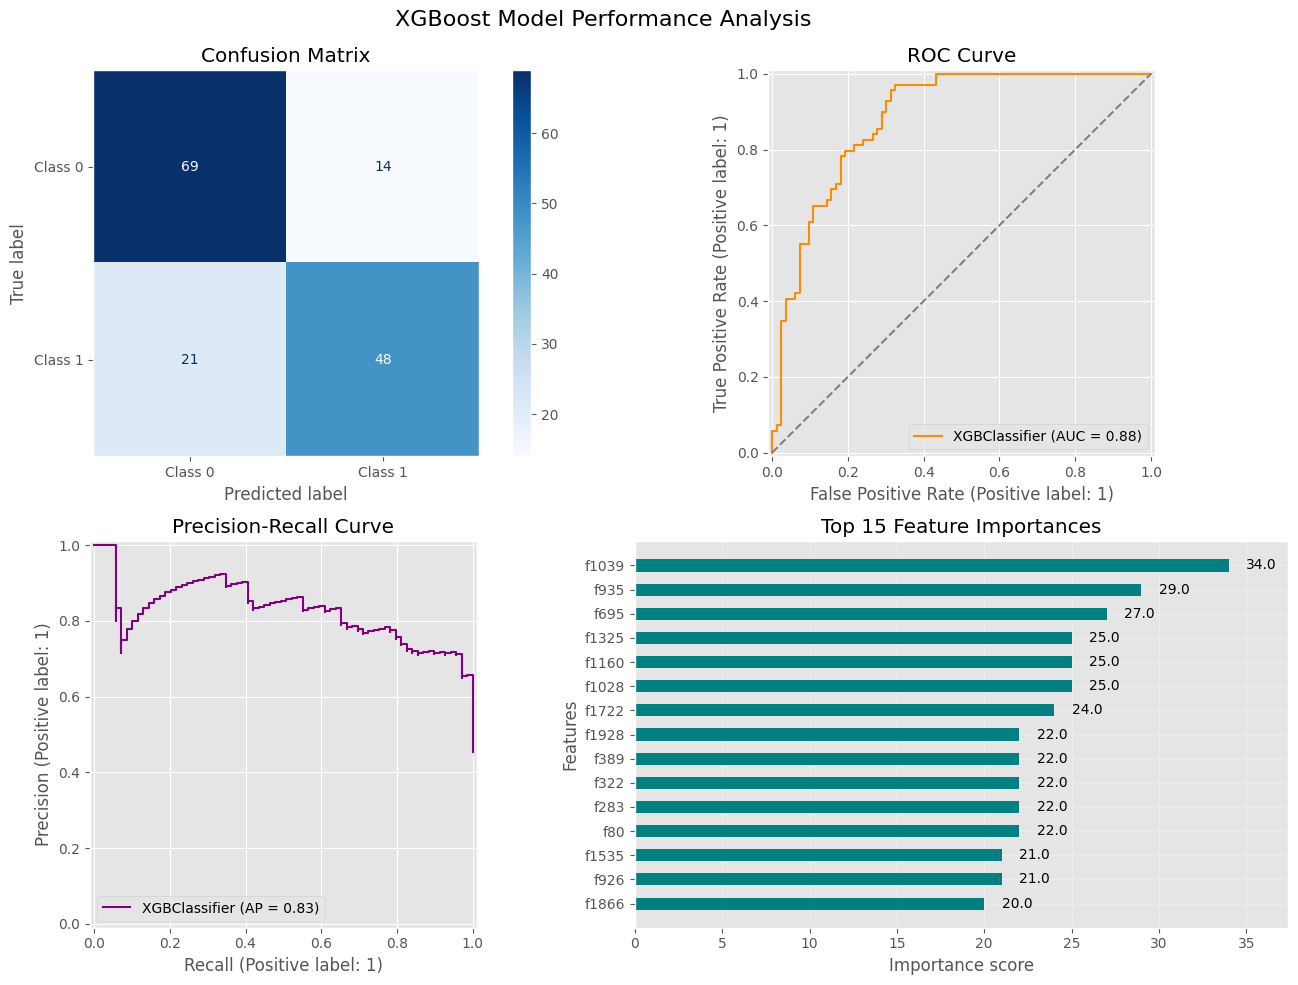

In [18]:
plot_model_performance(model, X_test, y_test)

### Save Model

In [11]:
MODEL_PATH = 'models/xgb_bace_model.pkl'
# joblib.dump(model, MODEL_PATH)

In [12]:
model = joblib.load(MODEL_PATH)

array([[<Axes: title={'center': 'Probability'}>]], dtype=object)

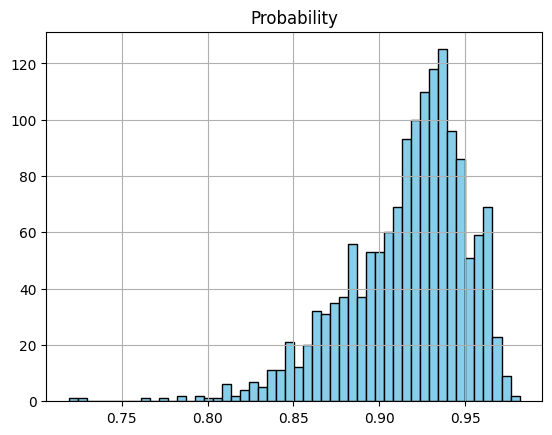

In [17]:
df = pd.DataFrame({"Probability": model.predict_proba(X)[:, 0]})
df.hist(bins=50, color='skyblue', edgecolor='black')